In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Regions

In [2]:
regionsDF = pd.read_csv("../originalDataset/noc_regions.csv")

In [3]:
regionsDF.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [4]:
len(regionsDF)

230

Existem 230 entradas

In [11]:
regionsDF.isna().sum()

NOC         0
region      3
notes     209
dtype: int64

A maioria das anotações são nulas

In [12]:
regionsDF[regionsDF['region'].isna()]

,NOC,region,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


Existem três regiões que não possuem nome. Uma é o UNKNOWN, Comitê Olímpico de Refugiados e Tuvalu. Podemos alterar todos os seus valores posteriormente.

In [13]:
regionsDF[~regionsDF['notes'].isna()]

,NOC,region,notes
1,AHO,Curacao,Netherlands Antilles
6,ANT,Antigua,Antigua and Barbuda
7,ANZ,Australia,Australasia
26,BOH,Czech Republic,Bohemia
51,CRT,Greece,Crete
88,HKG,China,Hong Kong
93,IOA,Individual Olympic Athletes,Individual Olympic Athletes
99,ISV,"Virgin Islands, US",Virgin Islands
143,NBO,Malaysia,North Borneo
147,NFL,Canada,Newfoundland


Pode-se ver que alguns NOC's representam regiões específicas de países maiores como Australasia na Australia, Bohemia na atual Chéquia, Creta na Grécia e NewFoundland no Canadá. Talvez a gente possa resolver isso ou deixar quieto.

# Athletes

In [5]:
athletesDf = pd.read_csv("../originalDataset/athlete_events.csv")

In [6]:
athletesDf.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [16]:
len(athletesDf)

271116

In [17]:
athletesDf.isna().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

Podemos perceber algumas coisas de acordo com a quantidade de dados faltando:
- A maioria dos atletas não receberam medalhas e, por isso, a grande maioria deles não possui uma entrada na coluna Medal
- Cerca de 1/5 das entradas estão sem dados sobre altura e peso
- Uma pequena parcela menor está sem idade

Para toda entrada com dado de peso e altura faltando, já que um mesmo atleta pode aparecer mais de uma vez (ver o ID do atleta na linha), podemos agrupar os dados por atleta e verificar se, em alguma de suas entradas, possui a informação que está faltando na outra entrada. A partir disso, podemos tentar completar seus dados. 

O mesmo pode ser feito para a idade do atleta apenas verificando em qual jogos ele participou e calcular a idade dele para os outros eventos.

## Tentando completar os dados

In [18]:
athletesByID = athletesDf.groupby('ID')

In [33]:
athletesByID.size().sort_values(ascending=False)[:5]

ID
77710     58
106296    39
115354    38
119591    36
44875     32
dtype: int64

In [72]:
athletesByID.ngroups #total num of groups. Egual to total num of athletes

135571

In [73]:
def countNullStats(groupByDf, col):
    """
    col: The col to check for null's/na's
    """
    noCol = set() #have a null value for that col in any row of group
    colFound = set() #does not have any null value for that col in any row of group
    noColButFound = set() #have a null value in some row but other row has a value
    
    for groupId, (groupedId, data) in enumerate(groupByDf):
        nas = data[col].isna() 
        if nas.sum() > 0:
            noCol.add(groupId)
            if len(data[~nas]) > 0:
                noColButFound.add(groupId)
        else:
            colFound.add(groupId)
    
    return noCol, colFound, noColButFound

In [56]:
noHeight, heightFound, noHeightButFound = countNullStats(athletesByID, 'Height')

In [58]:
print(f"allHeightsFound: {len(heightFound)}, hasNullHeight: {len(noHeight)}, hasNullButFoundToo: {len(noHeightButFound)} ")

allHeightsFound: 101655, hasNullHeight: 33916, hasNullButFoundToo: 0 


In [64]:
noWeight, weightFound, noweightButFound = countNullStats(athletesByID, 'Weight')

In [65]:
print(f"allWeightsFound: {len(weightFound)}, hasNullWeight: {len(noWeight)}, hasNullButFoundToo: {len(noweightButFound)} ")

allWeightsFound: 100686, hasNullWeight: 34885, hasNullButFoundToo: 0 


In [66]:
noAge, AgeFound, noAgeButFound = countNullStats(athletesByID, 'Age')

In [67]:
print(f"allAgesFound: {len(AgeFound)}, hasNullAge: {len(noAge)}, hasNullButFoundToo: {len(noAgeButFound)} ")

allAgesFound: 129203, hasNullAge: 6368, hasNullButFoundToo: 0 


De acordo com os resultados, cerca de 1/4 dos atletas realmente não possuem dados de peso ou altura. Além disso, cerca de 6300 atletas não possuem dados de idade. Assim sendo, a ideia original para completar os dados não poderá ser feita.

Uma opção é se desfazer de todas as entradas que possuem NaN values.

### Dados faltantes por ano de competição

In [14]:
athletesByYearAndID = athletesDf.groupby(["Year", "ID"])

In [15]:
def getNaNPerColPerYear(col, df, years):
    """
    Return a dict with the number of athletes with a NaN value over every 
    column in col for every year: {col1:{year1:5, year2:6}, col2:{year1:7, year2:0}}
    col: can be a string or a list
    df: Must be a DataFrame with a 'Year' col
    years: a set of unique years
    """
    cols = []
    if type(col) == str:
        cols = [col]
    elif type(col) == list:
        cols = col
    
    startingDictEveryYear = {year:0 for year in years}
    nanPerCol = dict()
    for col in cols:
        nanPerCol[col] = startingDictEveryYear.copy()
    
    for (year, athleteId), data in df:
        for col, nasNum in nanPerCol.items():
            if data[col].isna().sum() > 0:
                nanPerCol[col][year] +=1
    
    return nanPerCol

In [16]:
nansPerColPerYear = getNaNPerColPerYear(['Height', 'Weight', 'Age'], athletesByYearAndID, athletesDf['Year'].unique())

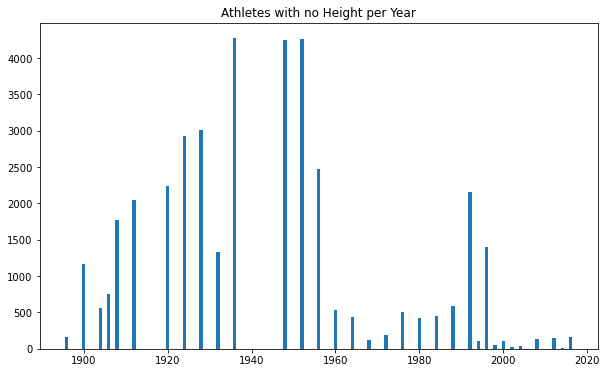

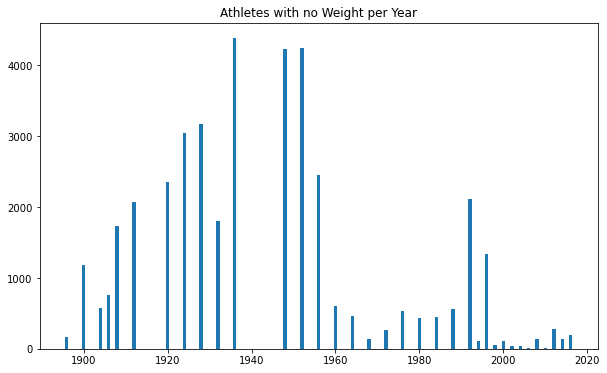

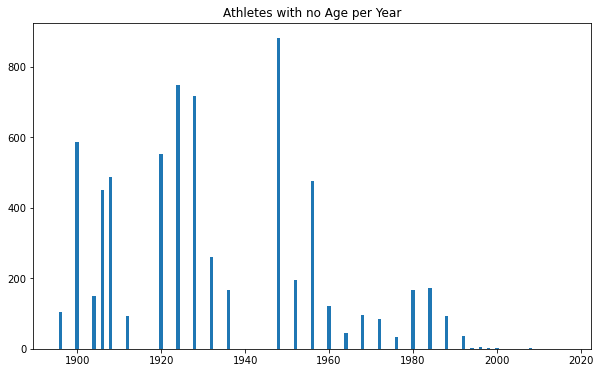

In [17]:
for col, nans in nansPerColPerYear.items():
    plt.figure(figsize=(10,6))
    plt.bar(*zip(*nans.items()))
    plt.title(f"Athletes with no {col} per Year")
    plt.show()

O gráfico de no Weight e no Height são muito semelhantes e, talvez, iguais

Pode-se perceber que, de 1996-2000 para cá, os dados estão mais completos para todos os casos.

Esses foram os números absolutos, mas, e a proporção?

In [41]:
totalAthletesPerYear = dict()
for year, athletesCount in athletesDf.groupby('Year')['ID'].nunique().items():
    totalAthletesPerYear[year] = athletesCount

In [42]:
def showProportionOfNaNsPerColumnPerYear(dictWithTotalPerYear, dictOfNaNsPerColPerYear):
    for col, nans in dictOfNaNsPerColPerYear.items():
        proportionOfNaNPerYear = dict()
        for year, nanCount in nans.items():
            proportionOfNaNPerYear[year] =  nanCount/dictWithTotalPerYear[year]

        plt.figure(figsize=(10,6))
        plt.bar(*zip(*proportionOfNaNPerYear.items()))
        plt.title(f"Proportion of athletes with no {col} per Year")
        plt.show()

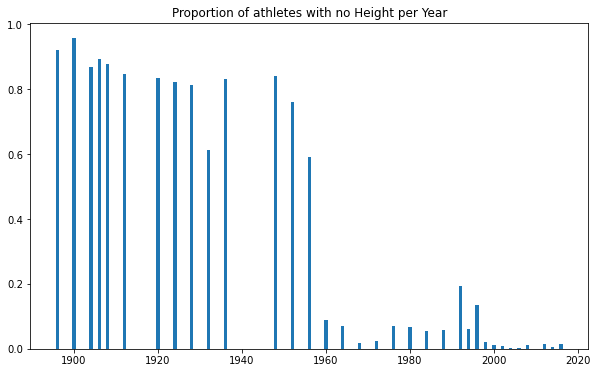

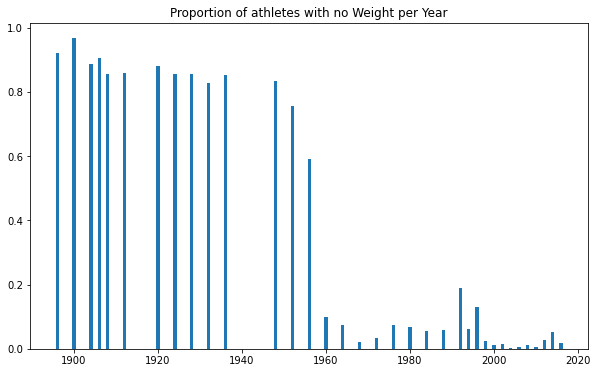

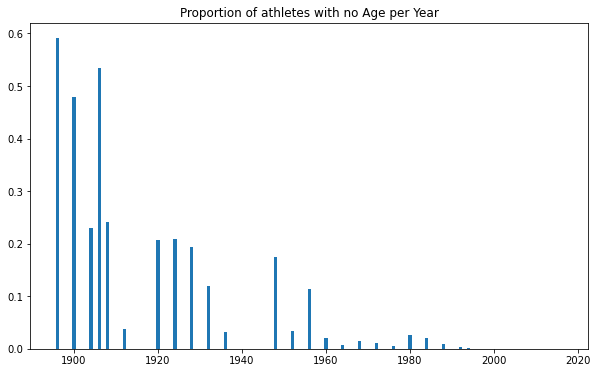

In [43]:
showProportionOfNaNsPerColumnPerYear(totalAthletesPerYear, nansPerColPerYear)

Pode-se perceber que a proporção de dados faltantes por coluna por ano é nula é muito baixa a partir de 1996 mais ou menos. Para os primeiros anos das olimpíadas, esse número é maior que 20%, passando de 90% dependendo da coluna

## Verificando dados faltantes apenas para medalhistas

Até agora, foi visto a proporção de NaNs por atleta no geral, entretanto, ao longo do trabalho, pode ser mais interessante focar apenas nos que realmente ganharam medalhas. Vamos ver a proporção de dados faltantes apenas para eles.

In [40]:
athletesWithMedal = athletesDf[~athletesDf['Medal'].isna()]

In [44]:
athletesWithMedalByYearAndID = athletesWithMedal.groupby(['Year','ID'])

In [47]:
nansMedalistsPerColPerYear = getNaNPerColPerYear(['Height', 'Weight', 'Age'], athletesWithMedalByYearAndID, athletesDf['Year'].unique())

In [48]:
totalMedalistsPerYear = dict()
for year, athletesCount in athletesWithMedal.reset_index().groupby('Year')['ID'].nunique().items():
    totalMedalistsPerYear[year] = athletesCount

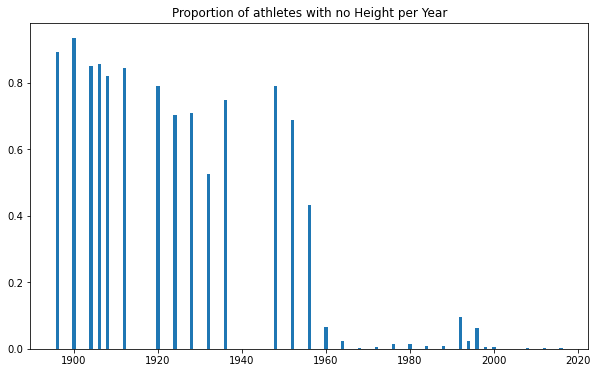

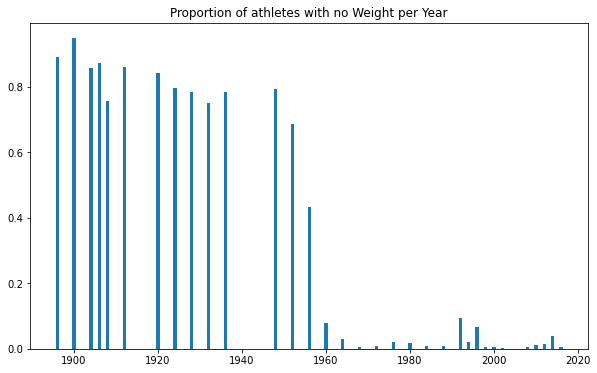

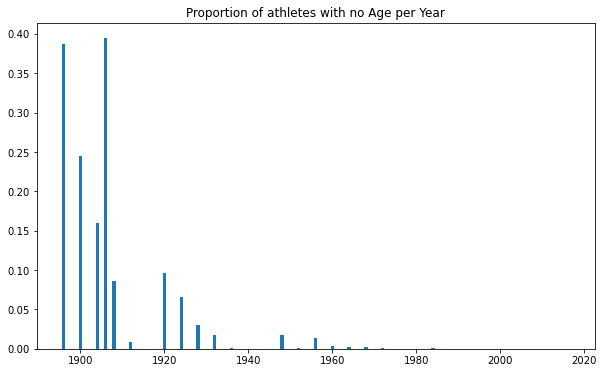

In [49]:
showProportionOfNaNsPerColumnPerYear(totalMedalistsPerYear, nansMedalistsPerColPerYear)

Pode-se perceber que, para os medalhistas, a situação dos dados começa a melhorar a partir de 1960, com, no máximo, cerca de 10% de NaN's. Ele ainda segue os picos de falta de dados no geral, mas entre os picos, os dados são bem mais completos. Dessa forma, poderíamos considerar focar apenas nos medalhistas sem NaN's nas nossas análises. Entretato, perderíamos a comparação dos medalhistas com todos que competiram em sua modalidade.